<a href="https://colab.research.google.com/github/LEESUSUSUSU/Image_based_question_answering_AI_project/blob/Suyeon/DL_project_BaselineReview2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import zipfile
from tqdm import tqdm

# 압축 파일 경로
zip_file_path = "/content/drive/MyDrive/dacon/open.zip"

# 압축을 풀 디렉토리 경로
extracted_dir_path = "/content/drive/MyDrive/dacon"

# 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 파일 내 파일의 개수 추출
    file_count = len(zip_ref.infolist())

    # tqdm을 사용하여 압축 해제 작업의 진행 상황 표시
    with tqdm(total=file_count) as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(file, extracted_dir_path)
            pbar.update(1)

print("Zip file extracted successfully!")


100%|██████████| 119152/119152 [12:21<00:00, 160.71it/s]

Zip file extracted successfully!


In [3]:
import os
files_train = os.listdir('/content/drive/MyDrive/dacon/image/train')
files_test = os.listdir('/content/drive/MyDrive/dacon/image/test')

image_files_train = [file for file in files_train if file.endswith('.jpg')]
image_files_test = [file for file in files_test if file.endswith('.jpg')]

num_images_train = len(image_files_train)
num_images_test = len(image_files_test)

num_images_train, num_images_test

(107231, 11915)

In [4]:
import os  #os 운영체제와 상호 작용 하기위 한 기능
import pandas as pd #판다스 데이터 조작을 위함

import torch  # 토치 높은 텐서 연산을 지원한다.
import torch.optim as optim # 최적화 알고리즘을 구현하는 모듈 sgd, adam 등 다양한 최적화
import torch.nn as nn # 딥러닝 모델을 구성하는데 필요한 다양한 레이어와 함수를 제공한다.
from torch.utils.data import Dataset, DataLoader #데이터를 배치 단위로 불러오는 반복자 역활을 합니다.



import torchvision.models as models # 사전 훈련된 모델들을 포함하고 있어, 이미지분류, 객체감지 드의 컴퓨터 비전 태스크를 쉽게 적용할 수 있다.
from torchvision import transforms # 이미지 전처리를 위한 다양한 기능을 제공하고 이미지를 텐서로 변화하거나 크기,조정,정규화,데이터 증강 등의 작업을 수행 할 수 있다.
from PIL import Image # 이미를 불러오고, 저장,처리 등을 제공하고 위의 torchvision과 함께 사용되어 데이터를 취급할때 유용하다.

from transformers import GPT2Tokenizer, GPT2Model # 자연어처리 nlp를 위한 사전 훈련된 모델을 제공한다.gpt-2를 제공

from tqdm.auto import tqdm #반복 작업의 진행 상태를 시각적으로 보여주는 라이브러리


In [5]:
class VQADataset(Dataset): # 이미지와 관련된 질문에 대한 답변을 학습하기 위해 사용되는 데이터

    def __init__(self, df, tokenizer, transform, img_path, is_test=False):
        self.df = df # df 데이터 프레임
        self.tokenizer = tokenizer # 토크나이저
        self.transform = transform # 이미지 변환기
        self.img_path = img_path # 이미지 경로
        self.is_test = is_test # 데스트 데이터 셋 여부


    def __len__(self):  # 데이터셋에 포함된 샘플의 총 개수를 변환
        return len(self.df) # 데이터 길이를 제공

    def __getitem__(self, idx):
        row = self.df.iloc[idx] # 특정 인덱스 샘플을 데이터셋에서 불러오고

        img_name = os.path.join(self.img_path, row['image_id'] + '.jpg') # 이미지 이름
        image = Image.open(img_name).convert('RGB') # 가져온 이미지를 rgb형식으로 불러와 저장
        image = self.transform(image) #이미지를 변환 저장

        #gpt-2 를 이용하기 때문에 인코더를 디코더는 하지 않는다.
        question = row['question'] # question을  토크나이징 해서 gpt-2 모델에 적합한 형태로 변환
        question = self.tokenizer.encode_plus( # 토큰라이즈.인코더 안에 세부 내용을 정리해준다.
            question, # 질문
            truncation=True, # 토큰의 길이가 max_length 보다 길면 일관성을 유지 하기 위해 필요함
            add_special_tokens=True, # 시작토큰과 종료 토근 텍스트에 자동으로 추가 해서 시작과 끝을 인식하는데 도움을 준다
            max_length=32, # 토큰화된 텍스트의 최대 길이를 지정한다.
            padding='max_length', # max_length 의 갖을 수 있도록 하는데 이는 배치 처리시 모든 샘플의 크기를 일정하게 유지
            return_attention_mask=True, #주의력 마스크 실제 데이터와 패딩을 구분할 수 있게 해주고 트랜스포머 기반 모델중에서 가장 중요 하다.
            return_tensors='pt', #반환되는 토큰화된 텍스트와 주의력 마스크를 토치 텐서로 반환하여 지정한다.
        )

        if not self.is_test:  # 테스트 모델이 아닐때
            answer = row['answer'] # 답변처리
            answer = self.tokenizer.encode_plus(
                answer,
                max_length=32,
                padding='max_length',
                truncation=True,
                return_tensors='pt')
            return {
                'image': image.squeeze(),
                'question': question['input_ids'].squeeze(),
                'answer': answer['input_ids'].squeeze()
            }
        else: # 테스트 모델일때
            return {
                'image': image,
                'question': question['input_ids'].squeeze(),
            }

# Model

In [6]:
class VQAModel(nn.Module):
    def __init__(self, vocab_size):  #모델을 초기화 함수 입니다. 모델에 필요한 레이어와 변수를 정의
        super(VQAModel, self).__init__() # 모델이 예측해야 하는 단어 집합의 크기
        self.vocab_size = vocab_size  # 출력데이터에 사용

        self.resnet = models.resnet50(pretrained=True) #사전 훈련된 모델을 불러와 이미지 특성을 추출
        self.gpt2 = GPT2Model.from_pretrained('gpt2') # gpt2 모델을 불러옴
        self.gpt2.resize_token_embeddings(vocab_size) # 추가한 [PAD] 토큰 반영

        combined_features_size = 1000 + self.gpt2.config.hidden_size # resnet이 1000 차원임 그래서 최종 벡터의 크기를 줘서 이미지 특성을 추출함
        self.classifier = nn.Linear(combined_features_size, vocab_size) # 결합된 이미지 와 텍스트 특성을 사용해 최종 답변 예측

    def forward(self, images, question): # 실제 데이터 처리
        image_features = self.resnet(images) # 이미지 배치
        image_features = image_features.view(image_features.size(0),-1) # 토큰화된 형태 -1 를 사용해서 남어지 원소의 배치들 분배 하고 순차적으로 나열

        outputs = self.gpt2(question) # 질문특성 추출
        output_features = outputs.last_hidden_state # [batch, sequence, hidden] 으닉 상태를 질문 득성

        # 이미지 특성을 gpt-2 모델의 출력과 같은 차원으로 확장 해줌
        image_features = image_features.unsqueeze(1).expand(-1, output_features.size(1),-1) # [batch, sequence, 1000]

        # 결합하여 최종 특성 벡터를 생성
        combined = torch.cat([image_features, output_features], dim=-1) # [batch, sequence, 1000+hidden]
        # 결합된 특성 벡터를 분류기에 통과시켜 각 단어에 대한 확률 분포 예측
        output = self.classifier(combined) # [batch, vocab_size]
        return output

# Dataloader

In [7]:
# 데이터 불러오기
# 데이터 불러오기
train_df = pd.read_csv('/content/drive/MyDrive/dacon/train.csv') #train.csv 불러오기
test_df = pd.read_csv('/content/drive/MyDrive/dacon/test.csv') #test.csv  불러오기 등등
sample_submission = pd.read_csv('/content/drive/MyDrive/dacon/sample_submission.csv') # 무튼 불러오기
train_img_path = '/content/drive/MyDrive/dacon/image/train/'
test_img_path = '/content/drive/MyDrive/dacon/image/test/'



# dataset & dataloader
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') # 훈련된 톤큰나이저 를 불러온다.
tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # 토큰 추가 시작 끝
vocab_size = len(tokenizer) # 전체 단어 집합 크기를 변수에 저장

transform = transforms.Compose([ # 데이터 전처리 변환
    transforms.Resize((224, 224)), # 이미지 데이터 전처리를 하기 위한 트렌스포머 resziesms 크기 조정
    transforms.ToTensor(), # 이미지를 텐서로 수정
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 픽셀 값을 정규화
])

#데이터셋 및 데이터로더 설정
train_dataset = VQADataset(train_df, tokenizer, transform, train_img_path, is_test=False) #위에 만든 클래스를 사용함
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # 생성된 데이터셋 기반으로 로드 함 배친는 64

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

# Train & Inference

In [9]:
def train(model, loader, optimizer, criterion, num_epochs):
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0
        processed_batches = 0

        for data in tqdm(loader, total=len(loader)):
            try:
                images = data['image'].to(device)
                question = data['question'].to(device)
                answer = data['answer'].to(device)

                optimizer.zero_grad()

                outputs = model(images, question)
                loss = criterion(outputs.view(-1, outputs.size(-1)), answer.view(-1))
                total_loss += loss.item()

                loss.backward()
                optimizer.step()

                processed_batches += 1

            except FileNotFoundError as e:
                print(f"Warning: Skipping missing file {e.filename}")
                continue

        if processed_batches > 0:
            avg_loss = total_loss / processed_batches
        else:
            avg_loss = 0


        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss}')
        loss_history.append(avg_loss)

    return  avg_loss , loss_history



In [ ]:
# def loss_history(avg_loss):
#   loss_history = []
#   loss_history.append(avg_loss)

#   return loss_history



In [10]:
def inference(model, loader):  # 데이터 추론 할거
    model.eval() # 모델을 평가 모드로 설정하는 것임
    preds = [] # 그래서 preds 임
    with torch.no_grad(): #기울기 계산할 필요 없어서 비활성화 후 메모리 사용량 줄이고 계산 속도를  향상
        for data in tqdm(loader, total=len(loader)):  # 사실 위랑 비슷함
            images = data['image'].to(device)
            question = data['question'].to(device)

            outputs = model(images, question) # [batch, sequence, vocab]

            _, pred = torch.max(outputs, dim=2) # values, indices = _, pred
            preds.extend(pred.cpu().numpy()) # cpu를 사용하는것은 넘파이를 사용을 용이 하기 위해서 그렇게 하는것

    return preds # 예측 결과 수행한값 반환 하는 것.

#Run!

In [11]:
# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is {device}")

# 모델 초기화 및 device 설정
model = VQAModel(vocab_size).to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# 학습 횟수 설정
num_epochs = 1

# 학습 과정 실행
avg_loss, loss_histroy = train(model, train_loader, optimizer, criterion, num_epochs)

for i in loss_histroy:
    print(f"loss_history : {i}")


# 학습 결과 출력
print(f"Average Loss after {num_epochs} epoch(s): {avg_loss:.4f}")


Current device is cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/5618 [00:00<?, ?it/s]

Epoch 1/1, Average Loss: 0.22258609611555621
loss_history : 0.22258609611555621
Average Loss after 1 epoch(s): 0.2226


1epoch 말고 진행을 하지 않았기때문에 그래프 그리기가 힘들 것.


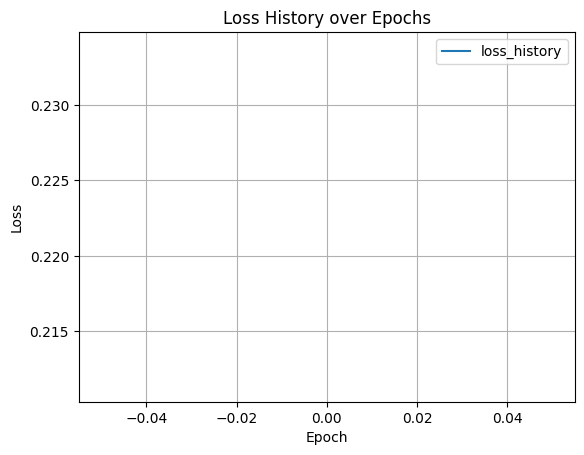

In [14]:
import matplotlib.pyplot as plt


#아고 오타나있네
# loss_history 시각화
plt.plot(loss_histroy, label='Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Post-Processing

In [15]:
# 결과를 후처리 하는 가정임 불필요한 패딩 토큰 제거하고

# Dataset & DataLoader
test_dataset = VQADataset(test_df, tokenizer, transform, test_img_path, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# inference
preds = inference(model, test_loader)

no_pad_output = []
for pred in preds:
    output = pred[pred != 50257] # [PAD] token 제외
    no_pad_output.append(tokenizer.decode(output).strip()) # 토큰 id -> 토큰

  0%|          | 0/633 [00:00<?, ?it/s]

In [19]:
# 모델 상태 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/dacon/model_state.pth')

# 학습 데이터(손실 이력) 저장
import json
with open('/content/drive/MyDrive/dacon/loss_history.json', 'w') as f:
    json.dump(loss_histroy, f)




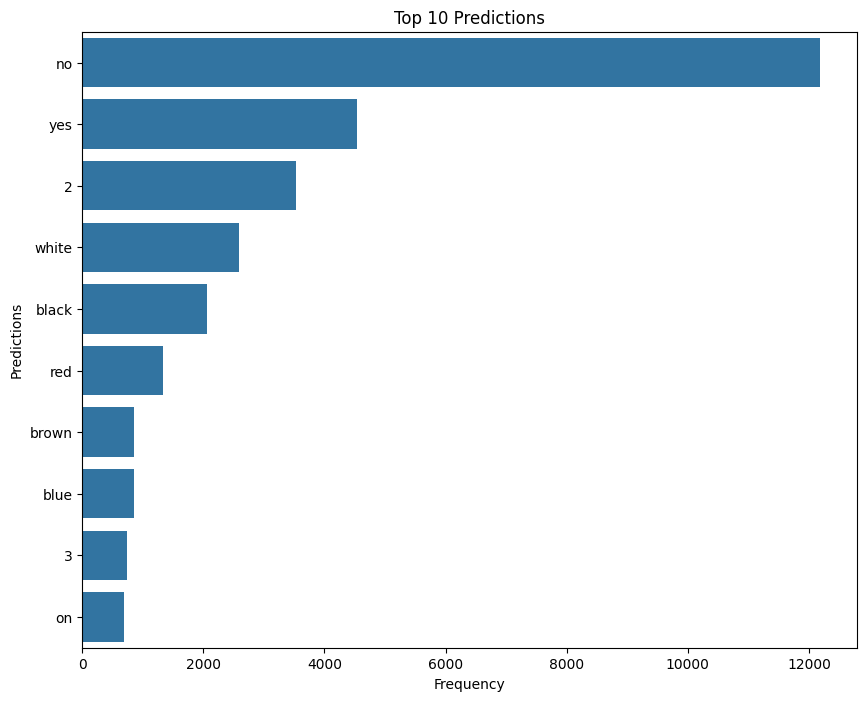

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# no_pad_output에는 패딩 토큰이 제거된 후의 모든 예측 결과가 담겨 있습니다.
# 각 예측 결과의 빈도수 계산
pred_frequencies = Counter(no_pad_output)

# 가장 빈번한 상위 10개 결과 추출
most_common_preds = pred_frequencies.most_common(10)
preds, freqs = zip(*most_common_preds)

# 시각화
plt.figure(figsize=(10, 8))
# seaborn의 barplot은 x와 y 인자를 키워드 인자로 받습니다.
sns.barplot(x=list(freqs), y=list(preds))
plt.title('Top 10 Predictions')
plt.xlabel('Frequency')
plt.ylabel('Predictions')
plt.show()


#Submission

In [ ]:
sample_submission['answer'] = no_pad_output
sample_submission.to_csv('/content/drive/MyDrive/dacon/submission_baselinere2.csv', index=False)